In [1]:
from typing import Tuple, List
from glob import glob

import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.utils.data
from scipy.ndimage.interpolation import rotate
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet

from data_augmentation import *

In [125]:
class Dataset(torch.utils.data.Dataset):
    """マスクの生成→データセット"""
    def __init__(self,
                 img_paths: List[np.array],
                 mask_paths: List[np.array],
                 train=False):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.train = train

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx) -> Tuple[np.ndarray, np.ndarray]:
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]
        resize = Resize()

        image = np.load(img_path)
        image = image.astype('float32') / image.max()
        if len(image.shape) == 2:
            image = np.reshape(image, [image.shape[0], image.shape[1], 1])
        image = image.transpose(2, 0, 1) # (channel, width, height) に変換
        image = resize(image)

        mask = np.load(mask_path) # (channel, width, height) になってる
        mask = mask.astype('uint8')
        mask = resize(mask)

        # 普通にdatasetのtransformでimageとmaskをランダムでtransformかけようとすると、
        # imageとmaskそれぞれにrandomがかかるっぽい。
        if self.train:
            # Data augmentation of position
            # Don't augment data of twenty percent.
            random_num = np.random.random()

            # Random crop or Move
            move = Move(rate=1.0, max_move_rate=0.2)
            image, mask = move(image, mask)
 
            # Data augmentation of brightness
            #adjust_gamma = Adjust_gamma(rate=0.7, gamma_range=(0.7, 1.4))
            #image = adjust_gamma(image)

            # Equalize_hist
            #equalize = Equalize(rate=0.2)
            #image = equalize(image)


        image = torch.from_numpy(image.copy().astype(np.float32))
        mask = torch.from_numpy(mask.copy().astype(np.float32))

        return image, mask

In [8]:
img_paths = glob('inputs/image_20190930/*')
mask_paths = glob('inputs/mask_20190930/*')

In [10]:
a = np.load(mask_paths[0])

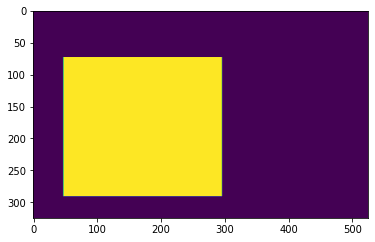

In [11]:
plt.imshow(a[0])

In [126]:
train_data = Dataset(img_paths, mask_paths, train=True)

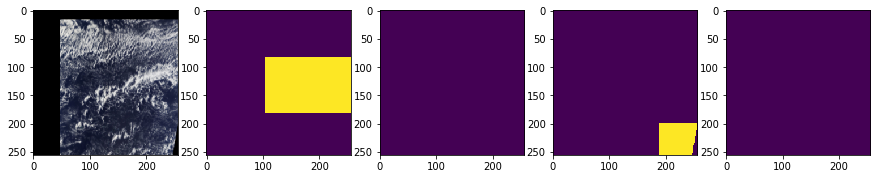

In [128]:
plt.figure(figsize=(15,5))
data = train_data[15]
plt.subplot(1,5,1)
plt.imshow(data[0].numpy().transpose(1,2,0))
plt.subplot(1,5,2)
plt.imshow(data[1].numpy().transpose(1,2,0)[:,:,0])
plt.subplot(1,5,3)
plt.imshow(data[1].numpy().transpose(1,2,0)[:,:,1])
plt.subplot(1,5,4)
plt.imshow(data[1].numpy().transpose(1,2,0)[:,:,2])
plt.subplot(1,5,5)
plt.imshow(data[1].numpy().transpose(1,2,0)[:,:,3])

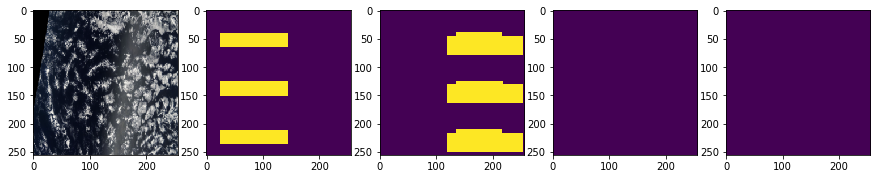

In [8]:
plt.figure(figsize=(15,5))
data = train_data[0]
plt.subplot(1,5,1)
plt.imshow(data[0].numpy().transpose(1,2,0))
plt.subplot(1,5,2)
plt.imshow(data[1].numpy().transpose(1,2,0)[:,:,0])
plt.subplot(1,5,3)
plt.imshow(data[1].numpy().transpose(1,2,0)[:,:,1])
plt.subplot(1,5,4)
plt.imshow(data[1].numpy().transpose(1,2,0)[:,:,2])
plt.subplot(1,5,5)
plt.imshow(data[1].numpy().transpose(1,2,0)[:,:,3])

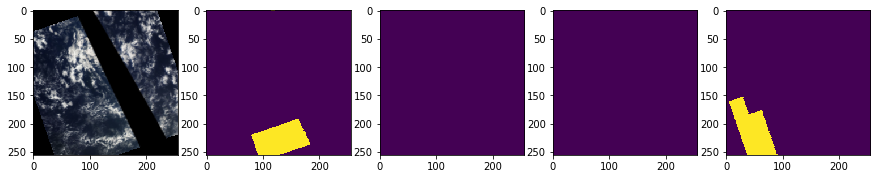

In [130]:
plt.figure(figsize=(15,5))
data = train_data[9]
plt.subplot(1,5,1)
plt.imshow(data[0].numpy().transpose(1,2,0))
plt.subplot(1,5,2)
plt.imshow(data[1].numpy().transpose(1,2,0)[:,:,0])
plt.subplot(1,5,3)
plt.imshow(data[1].numpy().transpose(1,2,0)[:,:,1])
plt.subplot(1,5,4)
plt.imshow(data[1].numpy().transpose(1,2,0)[:,:,2])
plt.subplot(1,5,5)
plt.imshow(data[1].numpy().transpose(1,2,0)[:,:,3])

In [163]:
data = torch.Tensor(np.random.rand(1,3,256,256))

In [129]:
model = EfficientNet.from_pretrained('efficientnet-b4')

Loaded pretrained weights for efficientnet-b4


In [130]:
base_layers = list(model.children())

In [155]:
data.shape

torch.Size([1, 3, 512, 512])

In [134]:
base_layers[0]

Conv2dStaticSamePadding(
  3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
  (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
)

In [136]:
import torch.nn as nn

In [164]:
first =  nn.Sequential(*base_layers[0:1])
print(first(data).shape)
data_1 = first(data)

torch.Size([1, 48, 128, 128])


In [165]:
second = nn.Sequential(*base_layers[2][0:5])
data_2 = second(data_1)
print(data_2.shape)

torch.Size([1, 32, 64, 64])


In [166]:
third = nn.Sequential(*base_layers[2][5:10])
data_3 = third(data_2)
print(data_3.shape)

torch.Size([1, 56, 32, 32])


In [167]:
fource = nn.Sequential(*base_layers[2][10:15])
data_4 = fource(data_3)
print(data_4.shape)

torch.Size([1, 112, 16, 16])


In [168]:
fiveth = nn.Sequential(*base_layers[2][15:20])
data_5 = fiveth(data_4)
print(data_5.shape)

torch.Size([1, 160, 16, 16])


In [169]:
sixth = nn.Sequential(*base_layers[2][20:25])
data_6 = sixth(data_5)
print(data_6.shape)

torch.Size([1, 272, 8, 8])


In [170]:
sixth = nn.Sequential(*base_layers[2][25:])
data_7 = sixth(data_6)
print(data_7.shape)

torch.Size([1, 448, 8, 8])


1302

In [213]:
class FPA(nn.Module):
    def __init__(self, channels=2048):
        """
        Feature Pyramid Attention
        :type channels: int
        """
        super(FPA, self).__init__()
        channels_mid = int(channels/4)

        self.channels_cond = channels

        # Master branch
        self.conv_master = nn.Conv2d(self.channels_cond, channels, kernel_size=1, bias=False)
        self.bn_master = nn.BatchNorm2d(channels)

        # Global pooling branch
        self.conv_gpb = nn.Conv2d(self.channels_cond, channels, kernel_size=1, bias=False)
        self.bn_gpb = nn.BatchNorm2d(channels)

        # C333 because of the shape of last feature maps is (16, 16).
        self.conv7x7_1 = nn.Conv2d(self.channels_cond, channels_mid, kernel_size=(7, 7), stride=2, padding=3, bias=False)
        self.bn1_1 = nn.BatchNorm2d(channels_mid)
        self.conv5x5_1 = nn.Conv2d(channels_mid, channels_mid, kernel_size=(5, 5), stride=2, padding=2, bias=False)
        self.bn2_1 = nn.BatchNorm2d(channels_mid)
        self.conv3x3_1 = nn.Conv2d(channels_mid, channels_mid, kernel_size=(3, 3), stride=2, padding=1, bias=False)
        self.bn3_1 = nn.BatchNorm2d(channels_mid)

        self.conv7x7_2 = nn.Conv2d(channels_mid, channels_mid, kernel_size=(7, 7), stride=1, padding=3, bias=False)
        self.bn1_2 = nn.BatchNorm2d(channels_mid)
        self.conv5x5_2 = nn.Conv2d(channels_mid, channels_mid, kernel_size=(5, 5), stride=1, padding=2, bias=False)
        self.bn2_2 = nn.BatchNorm2d(channels_mid)
        self.conv3x3_2 = nn.Conv2d(channels_mid, channels_mid, kernel_size=(3, 3), stride=1, padding=1, bias=False)
        self.bn3_2 = nn.BatchNorm2d(channels_mid)

        # Convolution Upsample
        self.conv_upsample_3 = nn.ConvTranspose2d(channels_mid, channels_mid, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_upsample_3 = nn.BatchNorm2d(channels_mid)

        self.conv_upsample_2 = nn.ConvTranspose2d(channels_mid, channels_mid, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_upsample_2 = nn.BatchNorm2d(channels_mid)

        self.conv_upsample_1 = nn.ConvTranspose2d(channels_mid, channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_upsample_1 = nn.BatchNorm2d(channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        :param x: Shape: [b, 2048, h, w]
        :return: out: Feature maps. Shape: [b, 2048, h, w]
        """
        # Master branch
        x_master = self.conv_master(x)
        x_master = self.bn_master(x_master)

        # Global pooling branch
        x_gpb = nn.AvgPool2d(x.shape[2:])(x).view(x.shape[0], self.channels_cond, 1, 1)
        x_gpb = self.conv_gpb(x_gpb)
        x_gpb = self.bn_gpb(x_gpb)

        # Branch 1
        x1_1 = self.conv7x7_1(x)
        x1_1 = self.bn1_1(x1_1)
        x1_1 = self.relu(x1_1)
        x1_2 = self.conv7x7_2(x1_1)
        x1_2 = self.bn1_2(x1_2)
        print(x1_2.shape)

        # Branch 2
        x2_1 = self.conv5x5_1(x1_1)
        x2_1 = self.bn2_1(x2_1)
        x2_1 = self.relu(x2_1)
        x2_2 = self.conv5x5_2(x2_1)
        x2_2 = self.bn2_2(x2_2)
        print(x2_2.shape)

        # Branch 3
        x3_1 = self.conv3x3_1(x2_1)
        x3_1 = self.bn3_1(x3_1)
        x3_1 = self.relu(x3_1)
        x3_2 = self.conv3x3_2(x3_1)
        x3_2 = self.bn3_2(x3_2)
        print(x3_2.shape)
        # Merge branch 1 and 2
        x3_upsample = self.relu(self.bn_upsample_3(self.conv_upsample_3(x3_2)))
        x2_merge = self.relu(x2_2 + x3_upsample)
        x2_upsample = self.relu(self.bn_upsample_2(self.conv_upsample_2(x2_merge)))
        x1_merge = self.relu(x1_2 + x2_upsample)

        x_master = x_master * self.relu(self.bn_upsample_1(self.conv_upsample_1(x1_merge)))

        #
        out = self.relu(x_master + x_gpb)

        return out


In [217]:
data = torch.Tensor(np.random.rand(16,256,32,32))

In [218]:
fpa = FPA(channels=256)

In [219]:
fpa(data).shape

torch.Size([16, 64, 16, 16])
torch.Size([16, 64, 8, 8])
torch.Size([16, 64, 4, 4])


torch.Size([16, 256, 32, 32])

In [173]:
data_7.shape

torch.Size([1, 448, 8, 8])

path 80がおかしい

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]

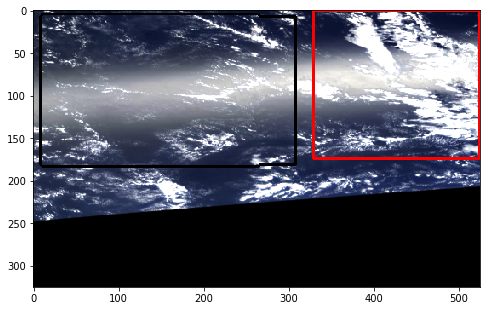

In [163]:
path =img_paths.index('inputs/image_gamma_1.1_0926\\img_fd5aa5d.npy')
img = np.load(img_paths[path])
mask = np.load(mask_paths[path])
for channel in range(mask.shape[0]):
    premask = cv2.morphologyEx(mask[channel], cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    labels, contours, hierarchy = cv2.findContours(premask.astype('uint8'), 
                                                   mode=cv2.RETR_LIST, 
                                                   method=cv2.CHAIN_APPROX_NONE)

    for i in range(0, len(contours)):
        if len(contours[i]) > 0:
            if channel == 0:
                color = (255,0,0)
            elif channel == 1:
                color = (0,255,0)
            elif channel == 2:
                color = (0,0,255)
            elif channel == 3:
                color = (0,0,0)
            img = cv2.polylines(img, contours[i], True, color, 2)
img = img/255
plt.figure(figsize=(8,8))
plt.imshow(img.transpose(1,0,2))
plt.plot()